# Laplacian Associative Memory (LAM) - SIGMA

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

In [1]:
from nn import LAM
import libtools

In [2]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

---

#### DATA

In [3]:
# src = libtools.preference_map(16, 25, 200)
src = np.load('../data/mat/SOM_orient_v1.npy')
src = libtools.downsample(src, 4)

print('Map:', src.shape)
print('min:', f"{src.min():.2f}", 'max:', f"{src.max():.2f}")

Map: (50, 50)
min: 0.00 max: 6.28


---

### HYPER-PARAMETERS

In [4]:
N = 8192                                # Neurons | Default: 30000
prob = 0.1                              # Sparsity
eta = 0.01                              # Epsilon / Learning rate
simlen = 3000                           # Steps / Epochs
gamma = 0.6                             # Inhibition ratio
norm_mode = 'asym'                      # Asymmetric Normalisation
alpha = -0.9                            # Ratio between local and global inhibition
P = src.shape[0] * src.shape[1]         # N Nodes

temp = 0.0215                           # Activation Probability

# Init condition (Center cell/pixel)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))

print('Neurons:', N)
print("Nodes:", P)
print('Start node:', start_node)
print(f"{P * 0.138:.2f} point attactors")

Neurons: 8192
Nodes: 2500
Start node: 1275
345.00 point attactors


---

### COMPUTE | SPATIAL (SIGMA_X)

In [5]:
sigmaX = np.array([0.0001, 0.0005, 0.001, 0.005, 0.01]).astype(float)
sigmaA = 0.1

In [6]:
Wx, Mx = [],[]
ticker = len(sigmaX)

for i in tqdm(range(ticker)):
    W = libtools.construct_SLAM(src, sigmaX[i], sigmaA)

    graph = LAM(N, P, prob, W, gamma, "asym", start_node)
    graph._set_weight(alpha)
    
    m_log, _, _ = graph.simulate_single(alpha, eta, simlen)
    m = m_log[-1,:].copy()
    m[start_node] = m.min()

    Wx.append(W)
    Mx.append(m)

100%|██████████| 5/5 [07:26<00:00, 89.37s/it]


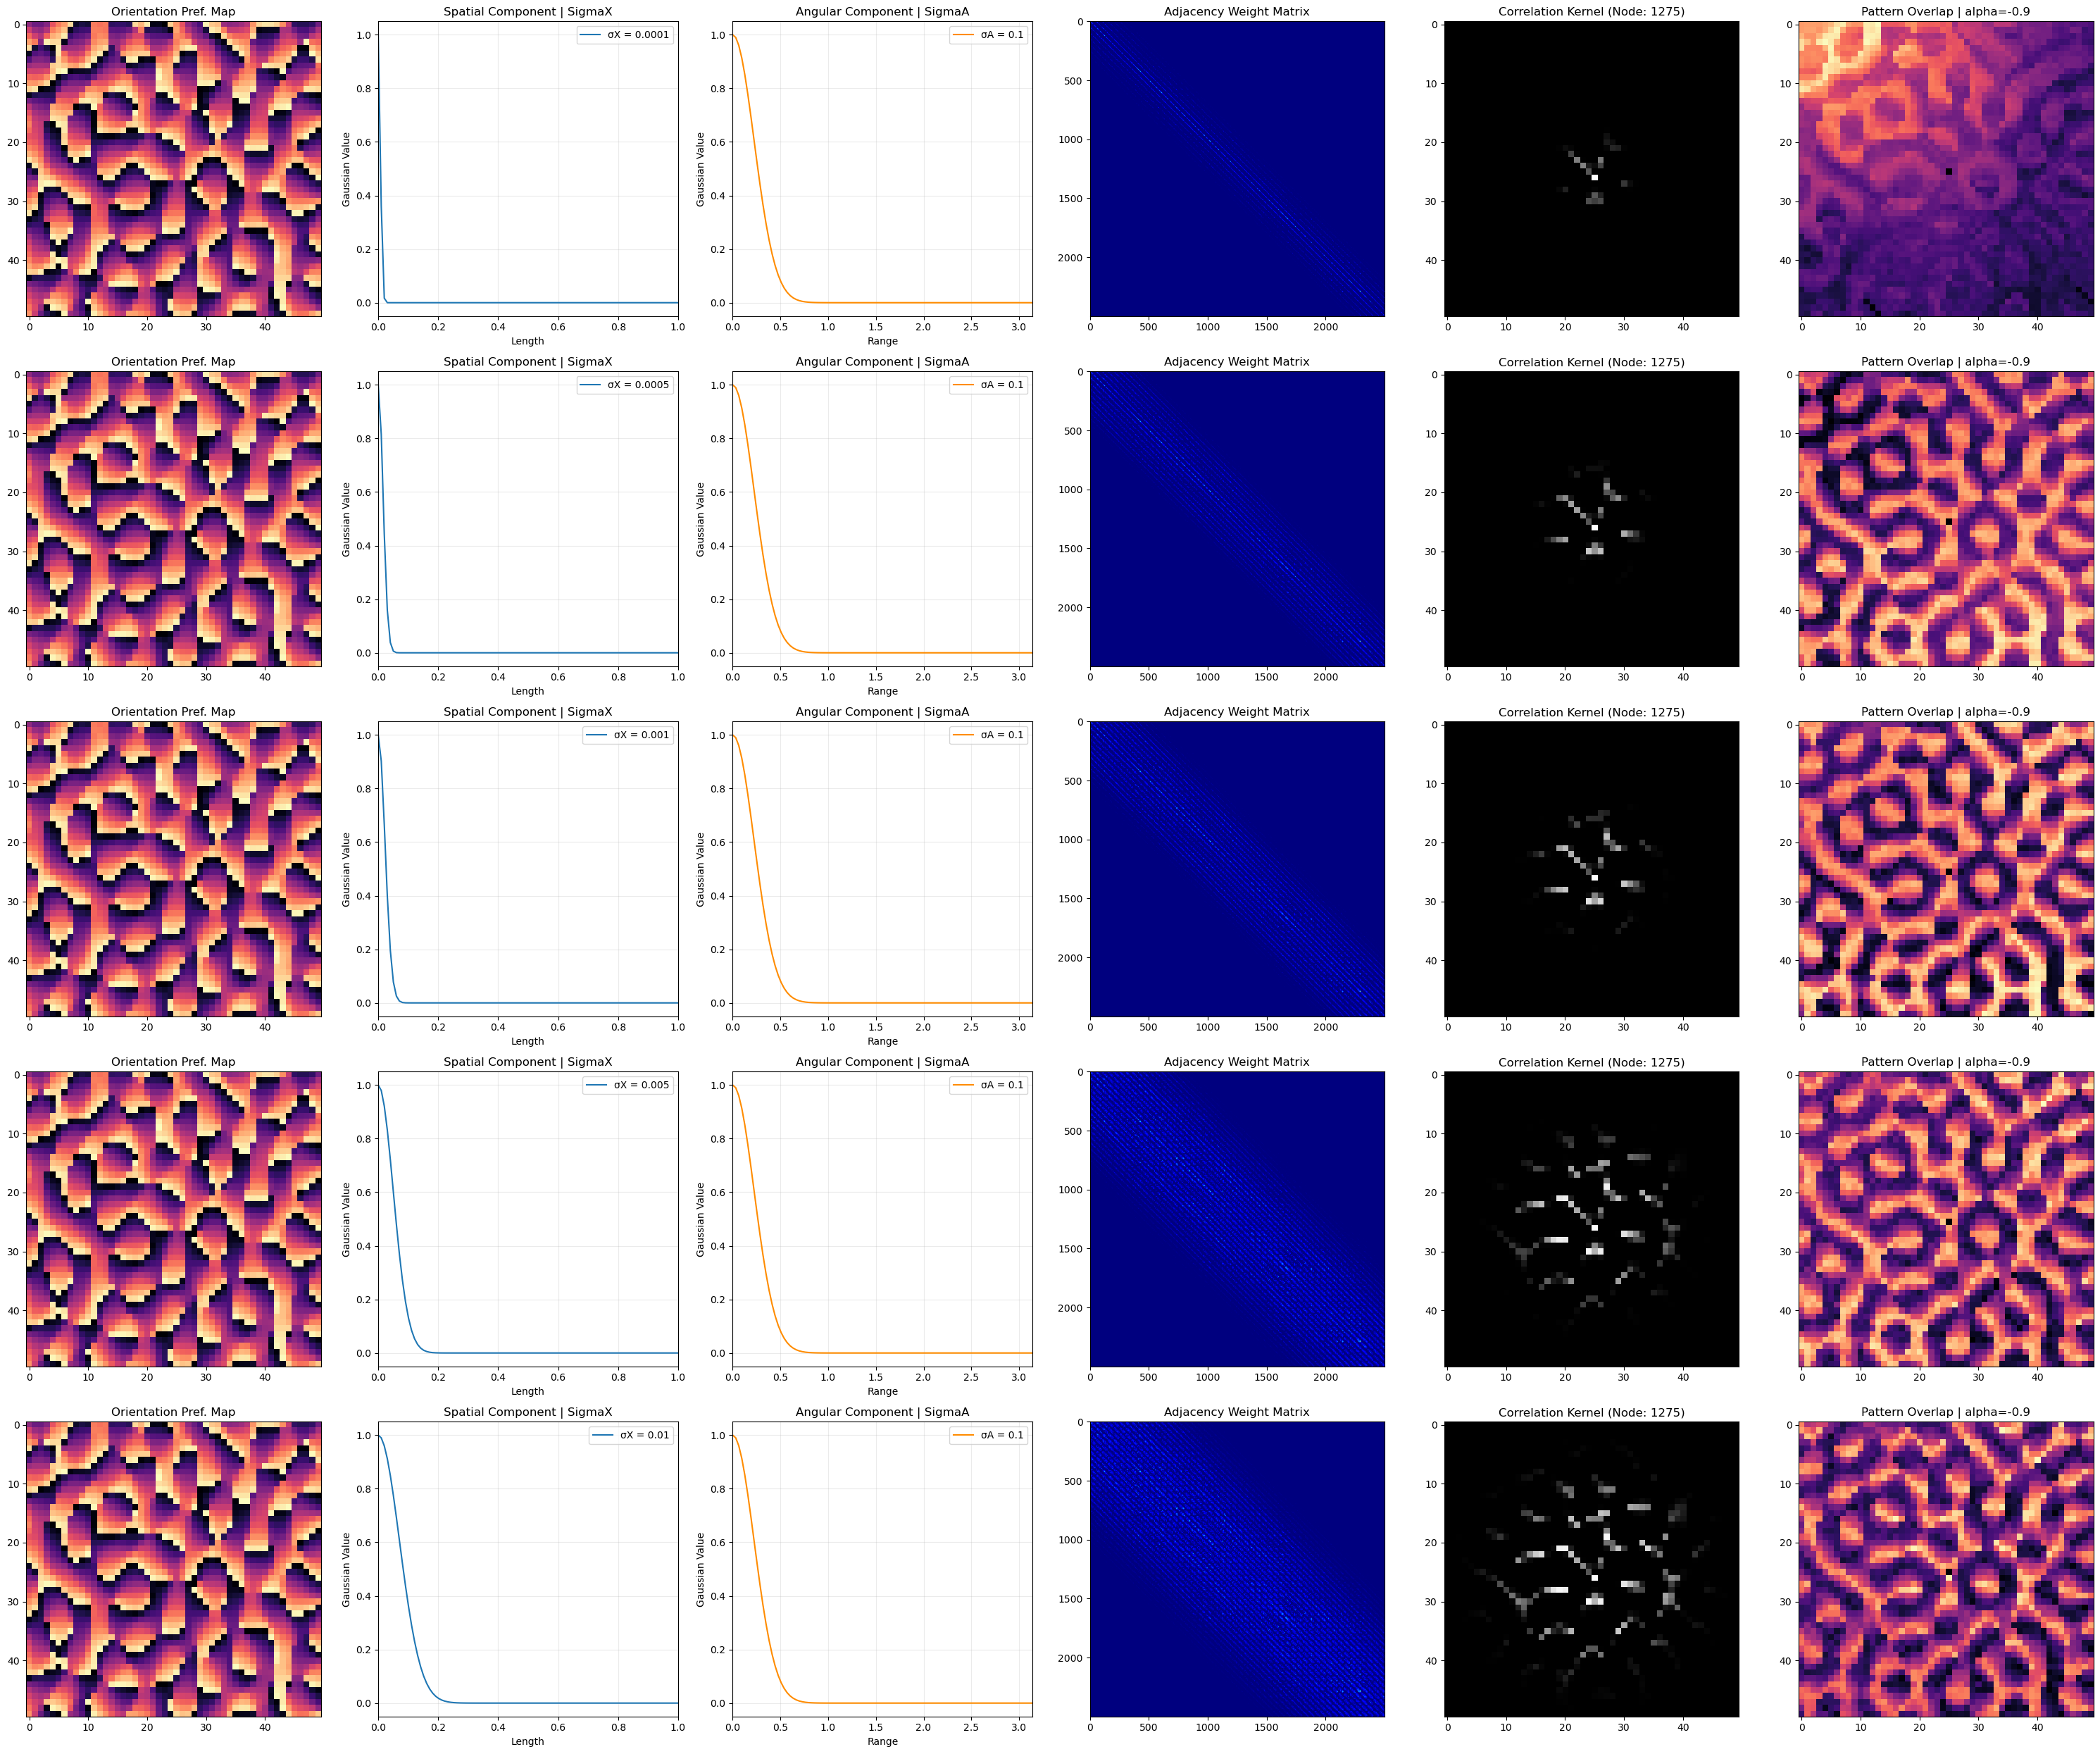

In [7]:
plt.figure(figsize=(30,5*ticker))
for i in range(ticker):
    plt.subplot(ticker, 6, i * 6 + 1)
    plt.imshow(src, 'magma')
    plt.title('Orientation Pref. Map')

    plt.subplot(ticker, 6, i * 6 + 2)
    dist_s = np.linspace(0, 1, 100)
    plt.plot(dist_s, libtools.gaussian(dist_s, sigmaX[i]), label=f'σX = {sigmaX[i]}')
    plt.title('Spatial Component | SigmaX')
    plt.xlabel('Length'), plt.ylabel('Gaussian Value')
    plt.xlim([0, 1]), plt.grid(alpha=0.25), plt.legend()

    plt.subplot(ticker, 6, i * 6 + 3)
    dist_a = np.linspace(0, np.pi, 100)
    plt.plot(dist_a, libtools.gaussian(dist_a, sigmaA), 'darkorange', label=f'σA = {sigmaA}')
    plt.title('Angular Component | SigmaA')
    plt.xlabel('Range'), plt.ylabel('Gaussian Value')
    plt.xlim([0, np.pi]), plt.grid(alpha=0.25), plt.legend()

    plt.subplot(ticker, 6, i * 6 + 4)
    plt.imshow(Wx[i], 'jet')
    plt.title('Adjacency Weight Matrix')

    plt.subplot(ticker, 6, i * 6 + 5)
    plt.imshow(Wx[i][start_node].reshape(src.shape), 'gray')
    plt.title('Correlation Kernel (Node: ' + str(start_node) + ')')

    plt.subplot(ticker, 6, i * 6 + 6)
    plt.imshow(Mx[i].reshape(src.shape), 'magma')
    plt.title('Pattern Overlap | alpha=' + str(alpha))

plt.tight_layout()

---

### COMPUTE | ORIENTATION (SIGMA_A)

In [8]:
sigmaX = 0.001
sigmaA = np.array([0.1, 0.5, 1, 2, 4]).astype(float)

In [9]:
Wa, Ma = [],[]
ticker = len(sigmaA)

for i in tqdm(range(ticker)):
    W = libtools.construct_SLAM(src, sigmaX, sigmaA[i])
    
    graph = LAM(N, P, prob, W, gamma, "asym", start_node)
    graph._set_weight(alpha)
    
    m_log, _, _ = graph.simulate_single(alpha, eta, simlen)
    m = m_log[-1,:].copy()
    m[start_node] = m.min()

    Wa.append(W)
    Ma.append(m)

100%|██████████| 5/5 [07:28<00:00, 89.62s/it]


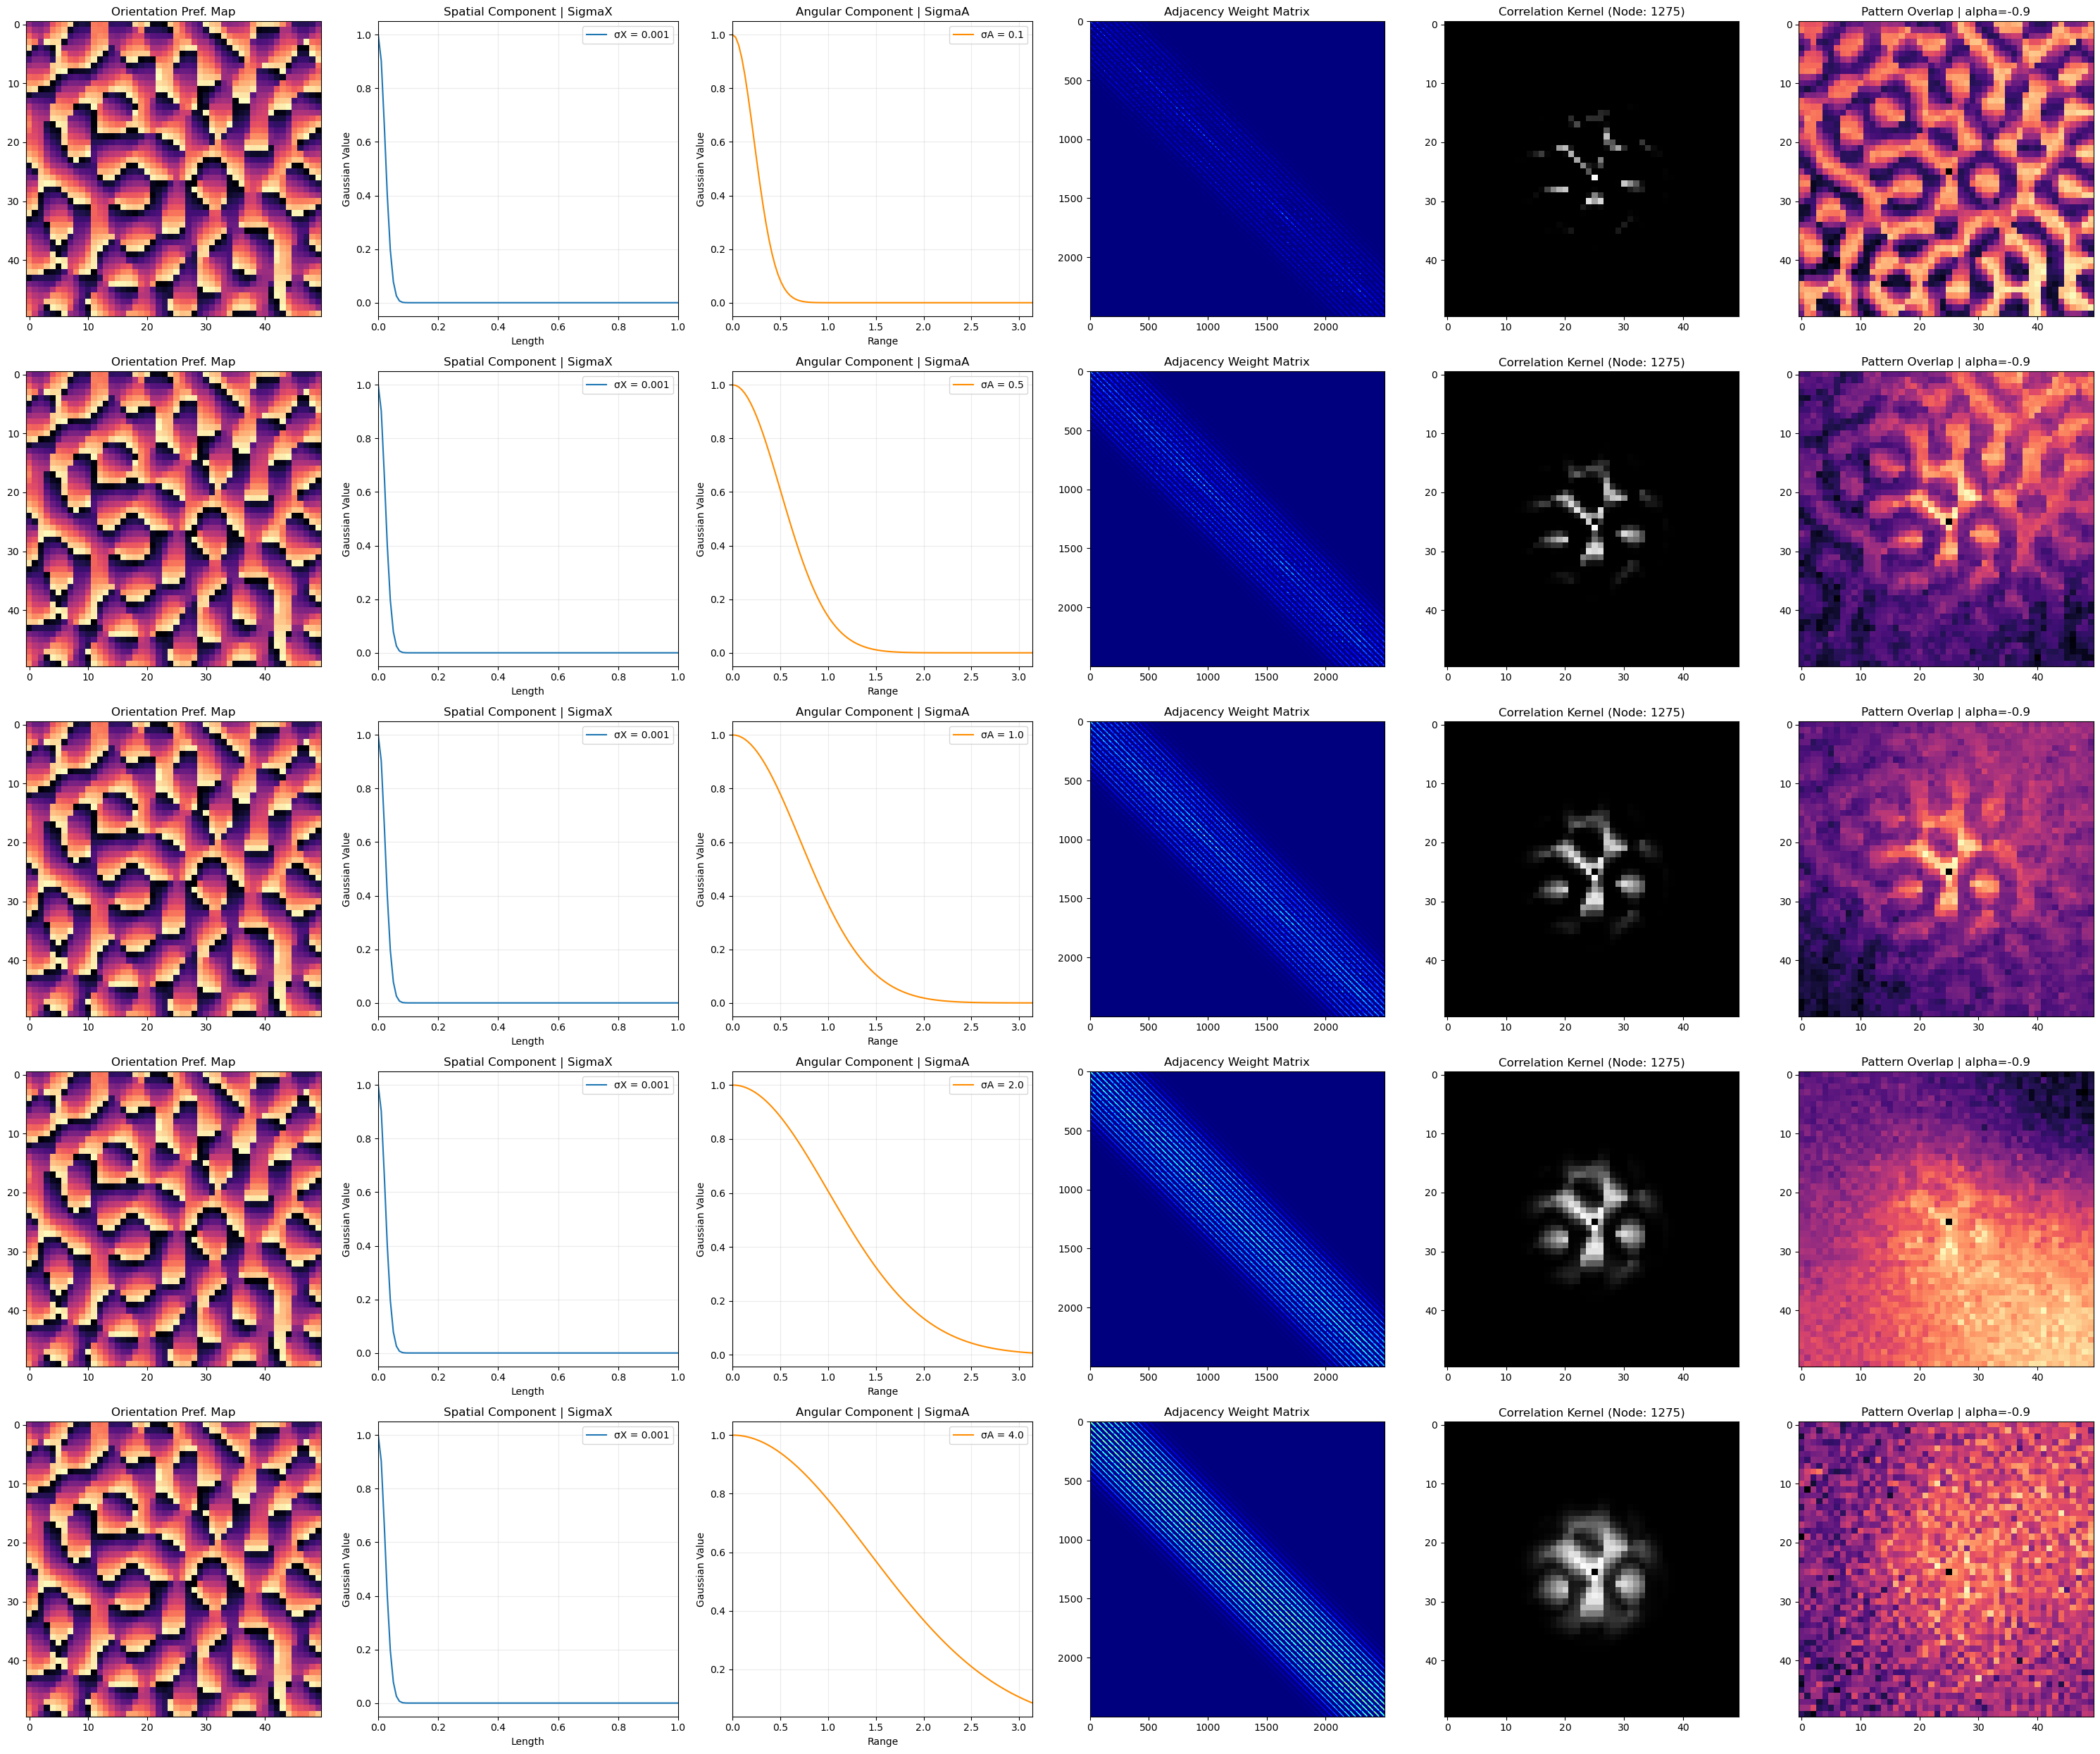

In [10]:
plt.figure(figsize=(30,5*ticker))
for i in range(ticker):
    plt.subplot(ticker, 6, i * 6 + 1)
    plt.imshow(src, 'magma')
    plt.title('Orientation Pref. Map')

    plt.subplot(ticker, 6, i * 6 + 2)
    dist_s = np.linspace(0, 1, 100)
    plt.plot(dist_s, libtools.gaussian(dist_s, sigmaX), label=f'σX = {sigmaX}')
    plt.title('Spatial Component | SigmaX')
    plt.xlabel('Length'), plt.ylabel('Gaussian Value')
    plt.xlim([0, 1]), plt.grid(alpha=0.25), plt.legend()

    plt.subplot(ticker, 6, i * 6 + 3)
    dist_a = np.linspace(0, np.pi, 100)
    plt.plot(dist_a, libtools.gaussian(dist_a, sigmaA[i]), 'darkorange', label=f'σA = {sigmaA[i]}')
    plt.title('Angular Component | SigmaA')
    plt.xlabel('Range'), plt.ylabel('Gaussian Value')
    plt.xlim([0, np.pi]), plt.grid(alpha=0.25), plt.legend()

    plt.subplot(ticker, 6, i * 6 + 4)
    plt.imshow(Wa[i], 'jet')
    plt.title('Adjacency Weight Matrix')

    plt.subplot(ticker, 6, i * 6 + 5)
    plt.imshow(Wa[i][start_node].reshape(src.shape), 'gray')
    plt.title('Correlation Kernel (Node: ' + str(start_node) + ')')

    plt.subplot(ticker, 6, i * 6 + 6)
    plt.imshow(Ma[i].reshape(src.shape), 'magma')
    plt.title('Pattern Overlap | alpha=' + str(alpha))

plt.tight_layout()